In [1]:
import numpy as np
import pandas as pd
import random
import os 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

SEED = 42

def set_reproducibility(seed):
    # 1. Standard Python randomness
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    # 2. Modern NumPy (Generator-based)
    # Use this 'rng' for any direct numpy random calls in your code
    rng = np.random.default_rng(seed)
    # Optional: still set legacy global seed for libraries that depend on it
    np.random.seed(seed) 

    # 3. PyTorch (CPU and all GPUs)
    torch.manual_seed(seed) # for CPU/GPU weight initialization
    torch.cuda.manual_seed_all(seed) # ensures all GPUs are seeded if you use multiple. 

    # 4. Forcing Deterministic GPU Algorithms (Crucial for 2026)
    # This ensures operations like convolutions are identical every run
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # New: Force error if deterministic op isn't possible
    torch.use_deterministic_algorithms(True) 
    
    return rng

# Initialize your setup
rng = set_reproducibility(SEED)

In [2]:
class PreprocessingDataset(Dataset):
    def __init__(self, df, target_col=None, drop_cols=None, stats=None):
        """
        df: Input DataFrame
        target_col: Name of the label column
        drop_cols: List of non-predictive columns to remove (e.g., ['PassengerId', 'Name'])
        stats: Dictionary containing training means, stds, and mappings
        """
        # 1. DROP UNWANTED COLUMNS
        df = df.copy()
        if drop_cols:
            df = df.drop(columns=[c for c in drop_cols if c in df.columns])
        
        # 2. SEPARATE TARGET & IDENTIFY TYPES
        if target_col and target_col in df.columns:
            self.target = torch.tensor(df[target_col].values, dtype=torch.float32)
            data_df = df.drop(columns=[target_col])
        else:
            self.target = None
            data_df = df
        
        # Automatic Column Type Identification
        num_cols = data_df.select_dtypes(include=['int64', 'float64']).columns
        cat_cols = data_df.select_dtypes(include=['object', 'category']).columns
        
        num_tensor = torch.tensor(data_df[num_cols].values, dtype=torch.float32)
        cat_data = data_df[cat_cols].astype(str).values.tolist()

        # 3. LEAKAGE-FREE SCALING & MAPPING
        if stats is None:
            # Training Mode: Calculate Stats
            self.means = torch.nanmean(num_tensor, dim=0)
            temp_num = torch.where(torch.isnan(num_tensor), self.means, num_tensor)
            self.stds = torch.std(temp_num, dim=0)
            self.stds[self.stds == 0] = 1.0 
            
            self.cat_mappings = self._build_mappings(cat_data)
            self.stats = {'means': self.means, 'stds': self.stds, 'mappings': self.cat_mappings}
        else:
            # Validation Mode: Reuse Train Stats
            self.means = stats['means']
            self.stds = stats['stds']
            self.cat_mappings = stats['mappings']
            self.stats = stats

        # 4. APPLY TRANSFORMATIONS
        # Impute and Standardize
        num_imputed = torch.where(torch.isnan(num_tensor), self.means, num_tensor)
        self.num_final = (num_imputed - self.means) / self.stds
        
        # Encode Categories
        self.cat_final = self._encode(cat_data)

        # 5. CONSOLIDATE INTO ONE TENSOR
        self.X = torch.cat([self.num_final, self.cat_final], dim=1)

    def _build_mappings(self, data):
        if not data: return []
        mappings = []
        num_cols = len(data[0])
        for col_idx in range(num_cols):
            unique_vals = sorted(list(set(row[col_idx] for row in data)))
            # BEST PRACTICE: Map known categories starting at index 0, 
            # and use len(unique_vals) as the 'Unknown' bucket.
            mapping = {val: i for i, val in enumerate(unique_vals)}
            mapping['__unknown__'] = len(unique_vals)
            mappings.append(mapping)
        return mappings

    def _encode(self, data):
        if not data: return torch.empty((len(self.num_final), 0))
        encoded = []
        for row in data:
            # Safer: Use the dedicated '__unknown__' index for unseen data
            encoded_row = [
                self.cat_mappings[i].get(val, self.cat_mappings[i]['__unknown__']) 
                for i, val in enumerate(row)
            ]
            encoded.append(encoded_row)
        return torch.tensor(encoded, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.target is not None:
            return self.X[idx], self.target[idx]
        return self.X[idx]


In [3]:
# Load data 
df = pd.read_csv("/kaggle/input/titanic/train.csv")
#test_df  = pd.read_csv("/kaggle/input/titanic/test.csv")

# --- 1. DATA CLEANING (Before Preprocessing) ---
# Drop columns that are unique IDs or too complex for a baseline
ID_COLS = ['PassengerId', 'Name', 'Ticket', 'Cabin']

# Validation split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['Survived'], random_state=SEED)
# Stratification: ensures both sets have the same class distribution—this is essential for stable validation.

# 2. Create Train Dataset (Calculates internal stats and drops IDs)
train_ds = PreprocessingDataset(train_df, target_col='Survived', drop_cols=ID_COLS)

# 3. Create Val Dataset (Reuses stats from train_ds and drops IDs)
val_ds = PreprocessingDataset(val_df, target_col='Survived', drop_cols=ID_COLS, stats=train_ds.stats)

# 4. DataLoaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

In [11]:
# Model definition
class BaselineNet(nn.Module): # The physical structure of the brain (the neurons).
    def __init__(self, input_size):
        super(BaselineNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.BatchNorm1d(16), # Added: Stabilizes inputs to the next layer
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
            #nn.Sigmoid() BCEWithLogitsLoss handles it.
        )
    
    def forward(self, x): # The thought process (data goes in, a decision comes out).
        return self.net(x.float()) # Force float32 for safety

# setup
# Fetch the first item to see its shape
# train_ds[0] returns a tuple: (features, label)
first_features, _ = train_ds[0]
#Get the number of features (the size of the input tensor)
input_size = first_features.shape[0] 
model = BaselineNet(input_size=input_size)

# criterion = nn.BCELoss() # Binary Cross Entropy for 0/1 prediction (how wrong was the decision?)
criterion = nn.BCEWithLogitsLoss() 
# Use AdamW for better out-of-the-box performance in 2026
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-2,           # Learning Rate: How fast to learn
    weight_decay=1e-2  # L2 Penalty: How much to punish complex models
)

In [4]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0, path='best_model.pt'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        # Higher score is better, so we use negative loss
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0
    def save_checkpoint(self, model):
        '''Saves model when validation loss decreases.'''
        torch.save(model.state_dict(), self.path)

In [12]:
# Setup device (e.g., 'cuda', 'mps' for Mac, or 'cpu')
# This code snippet dynamically assigns a hardware accelerator to your PyTorch model to ensure optimal performance during training or inference.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# The training and validation loop
train_losses = []
val_losses = []
epochs = 100 # Example duration
# Reduces learning rate by half if validation loss doesn't improve for 5 epochs
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
# Initialize Early Stopping
early_stopper = EarlyStopping(patience=10, path='best_model.pt')

for epoch in range(epochs):
    # --- PHASE 1: TRAINING ---
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        # Move data to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # .view(-1) is safer than .squeeze() for binary classification
        loss = criterion(outputs.view(-1), labels.float()) # Changes (64, 1) to (64)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    
    # Calculate average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss) # Log training loss

    # --- PHASE 2: VALIDATION ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation for efficiency
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels.float())
            running_val_loss += loss.item() * inputs.size(0)
            
    # Calculate average validation loss for the epoch
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss) # Log validation loss

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    #scheduler.step(epoch_val_loss)

    # --- PHASE 3: EARLY STOPPING CHECK (Outside the DataLoader loop) ---
    # Pass the epoch_val_loss and the model to save the best weights
    early_stopper(epoch_val_loss, model) 
    
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}. Restoring best weights...")
        # map_location ensures it loads correctly on any device
        model.load_state_dict(torch.load('best_model.pt', weights_only=True, map_location=device))
        break


Epoch 1/100 - Train Loss: 0.6686 | Val Loss: 0.6334
Epoch 2/100 - Train Loss: 0.5857 | Val Loss: 0.5679
Epoch 3/100 - Train Loss: 0.4838 | Val Loss: 0.4805
Epoch 4/100 - Train Loss: 0.4455 | Val Loss: 0.4584
Epoch 5/100 - Train Loss: 0.4353 | Val Loss: 0.4463
Epoch 6/100 - Train Loss: 0.4319 | Val Loss: 0.4471
Epoch 7/100 - Train Loss: 0.4203 | Val Loss: 0.4467
Epoch 8/100 - Train Loss: 0.4222 | Val Loss: 0.4439
Epoch 9/100 - Train Loss: 0.4147 | Val Loss: 0.4368
Epoch 10/100 - Train Loss: 0.4119 | Val Loss: 0.4413
Epoch 11/100 - Train Loss: 0.4180 | Val Loss: 0.4497
Epoch 12/100 - Train Loss: 0.4168 | Val Loss: 0.4344
Epoch 13/100 - Train Loss: 0.4044 | Val Loss: 0.4319
Epoch 14/100 - Train Loss: 0.4152 | Val Loss: 0.4492
Epoch 15/100 - Train Loss: 0.4201 | Val Loss: 0.4454
Epoch 16/100 - Train Loss: 0.4060 | Val Loss: 0.4438
Epoch 17/100 - Train Loss: 0.4067 | Val Loss: 0.4409
Epoch 18/100 - Train Loss: 0.4106 | Val Loss: 0.4304
Epoch 19/100 - Train Loss: 0.3944 | Val Loss: 0.4339
Ep

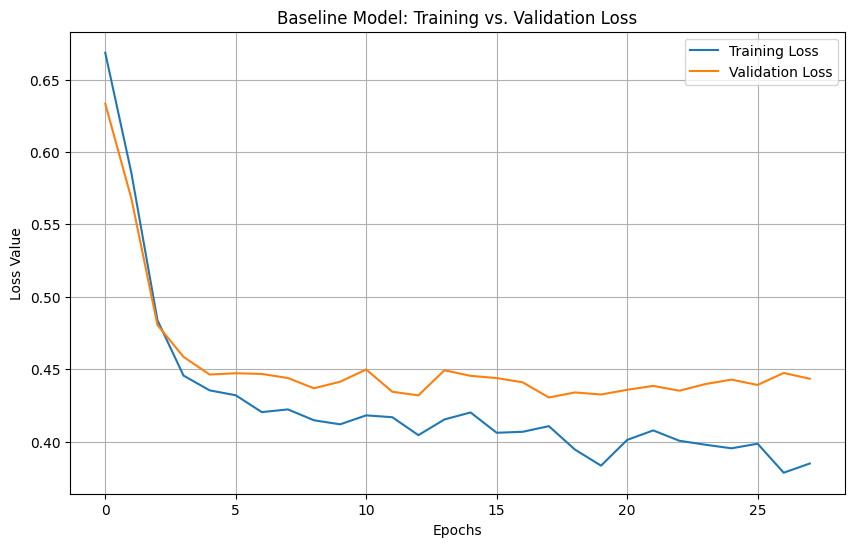

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Use labels so the legend knows which line is which
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

# Standard formatting for 2026 reports
plt.title('Baseline Model: Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend() # Automatically uses the labels defined above
plt.grid(True) # Makes it easier to pinpoint specific epochs
plt.show()


Overfitting Signal: Around Epoch 19, a gap begins to widen. The Train Loss continues to decrease (reaching 0.3848), but the Val Loss remains stuck in the 0.43–0.44 range. This indicates the model is starting to memorize the training data rather than generalizing to the validation set.


# Learning rate experiment

rain with:

lr = 1e-2
lr = 1e-3
lr = 1e-4

Plot training + validation loss for each.

You will see:

Too high → unstable
Too low → slow
Just right → smooth descent

In [17]:
# Model definition
class BaselineNet(nn.Module): # The physical structure of the brain (the neurons).
    def __init__(self, input_size):
        super(BaselineNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.BatchNorm1d(16), # Added: Stabilizes inputs to the next layer
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
            #nn.Sigmoid() BCEWithLogitsLoss handles it.
        )
    
    def forward(self, x): # The thought process (data goes in, a decision comes out).
        return self.net(x.float()) # Force float32 for safety

# setup
# Fetch the first item to see its shape
# train_ds[0] returns a tuple: (features, label)
first_features, _ = train_ds[0]
#Get the number of features (the size of the input tensor)
input_size = first_features.shape[0] 
model = BaselineNet(input_size=input_size)

# criterion = nn.BCELoss() # Binary Cross Entropy for 0/1 prediction (how wrong was the decision?)
criterion = nn.BCEWithLogitsLoss() 
# Use AdamW for better out-of-the-box performance in 2026
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,           # Learning Rate: How fast to learn
    weight_decay=1e-2  # L2 Penalty: How much to punish complex models
)

In [18]:
# Setup device (e.g., 'cuda', 'mps' for Mac, or 'cpu')
# This code snippet dynamically assigns a hardware accelerator to your PyTorch model to ensure optimal performance during training or inference.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# The training and validation loop
train_losses = []
val_losses = []
epochs = 100 # Example duration
# Reduces learning rate by half if validation loss doesn't improve for 5 epochs
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
# Initialize Early Stopping
early_stopper = EarlyStopping(patience=10, path='best_model.pt')

for epoch in range(epochs):
    # --- PHASE 1: TRAINING ---
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        # Move data to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # .view(-1) is safer than .squeeze() for binary classification
        loss = criterion(outputs.view(-1), labels.float()) # Changes (64, 1) to (64)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    
    # Calculate average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss) # Log training loss

    # --- PHASE 2: VALIDATION ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation for efficiency
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels.float())
            running_val_loss += loss.item() * inputs.size(0)
            
    # Calculate average validation loss for the epoch
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss) # Log validation loss

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    #scheduler.step(epoch_val_loss)

    # --- PHASE 3: EARLY STOPPING CHECK (Outside the DataLoader loop) ---
    # Pass the epoch_val_loss and the model to save the best weights
    early_stopper(epoch_val_loss, model) 
    
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}. Restoring best weights...")
        # map_location ensures it loads correctly on any device
        model.load_state_dict(torch.load('best_model.pt', weights_only=True, map_location=device))
        break


Epoch 1/100 - Train Loss: 0.7202 | Val Loss: 0.7112
Epoch 2/100 - Train Loss: 0.7106 | Val Loss: 0.7013
Epoch 3/100 - Train Loss: 0.6998 | Val Loss: 0.6933
Epoch 4/100 - Train Loss: 0.6935 | Val Loss: 0.6837
Epoch 5/100 - Train Loss: 0.6833 | Val Loss: 0.6730
Epoch 6/100 - Train Loss: 0.6715 | Val Loss: 0.6614
Epoch 7/100 - Train Loss: 0.6587 | Val Loss: 0.6472
Epoch 8/100 - Train Loss: 0.6462 | Val Loss: 0.6319
Epoch 9/100 - Train Loss: 0.6265 | Val Loss: 0.6154
Epoch 10/100 - Train Loss: 0.6109 | Val Loss: 0.5950
Epoch 11/100 - Train Loss: 0.5885 | Val Loss: 0.5750
Epoch 12/100 - Train Loss: 0.5675 | Val Loss: 0.5564
Epoch 13/100 - Train Loss: 0.5479 | Val Loss: 0.5412
Epoch 14/100 - Train Loss: 0.5282 | Val Loss: 0.5327
Epoch 15/100 - Train Loss: 0.5139 | Val Loss: 0.5170
Epoch 16/100 - Train Loss: 0.5067 | Val Loss: 0.5026
Epoch 17/100 - Train Loss: 0.4904 | Val Loss: 0.4931
Epoch 18/100 - Train Loss: 0.4878 | Val Loss: 0.4852
Epoch 19/100 - Train Loss: 0.4745 | Val Loss: 0.4733
Ep

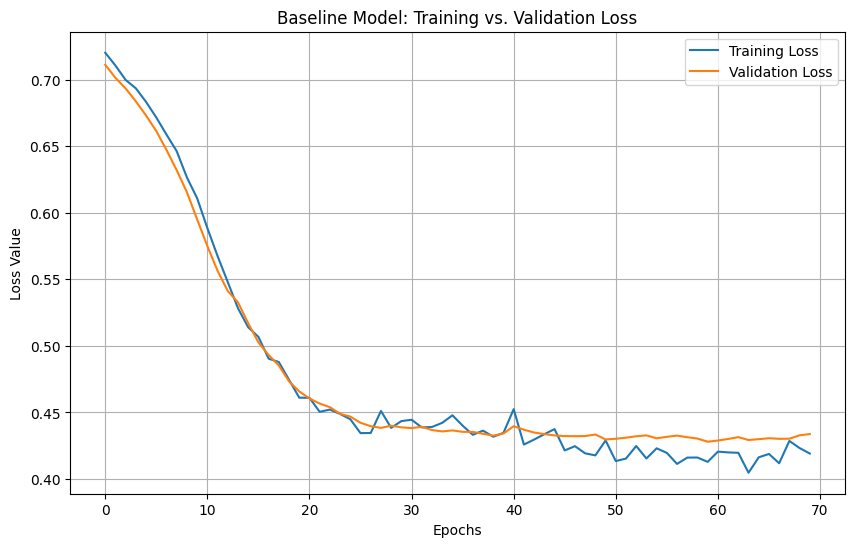

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Use labels so the legend knows which line is which
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

# Standard formatting for 2026 reports
plt.title('Baseline Model: Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend() # Automatically uses the labels defined above
plt.grid(True) # Makes it easier to pinpoint specific epochs
plt.show()

In [24]:
# Model definition
class BaselineNet(nn.Module): # The physical structure of the brain (the neurons).
    def __init__(self, input_size):
        super(BaselineNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.BatchNorm1d(16), # Added: Stabilizes inputs to the next layer
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
            #nn.Sigmoid() BCEWithLogitsLoss handles it.
        )
    
    def forward(self, x): # The thought process (data goes in, a decision comes out).
        return self.net(x.float()) # Force float32 for safety

# setup
# Fetch the first item to see its shape
# train_ds[0] returns a tuple: (features, label)
first_features, _ = train_ds[0]
#Get the number of features (the size of the input tensor)
input_size = first_features.shape[0] 
model = BaselineNet(input_size=input_size)

# criterion = nn.BCELoss() # Binary Cross Entropy for 0/1 prediction (how wrong was the decision?)
criterion = nn.BCEWithLogitsLoss() 
# Use AdamW for better out-of-the-box performance in 2026
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,           # Learning Rate: How fast to learn
    weight_decay=1e-2  # L2 Penalty: How much to punish complex models
)

In [25]:
# Setup device (e.g., 'cuda', 'mps' for Mac, or 'cpu')
# This code snippet dynamically assigns a hardware accelerator to your PyTorch model to ensure optimal performance during training or inference.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# The training and validation loop
train_losses = []
val_losses = []
epochs = 500 # Example duration
# Reduces learning rate by half if validation loss doesn't improve for 5 epochs
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)


for epoch in range(epochs):
    # --- PHASE 1: TRAINING ---
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        # Move data to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # .view(-1) is safer than .squeeze() for binary classification
        loss = criterion(outputs.view(-1), labels.float()) # Changes (64, 1) to (64)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    
    # Calculate average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss) # Log training loss

    # --- PHASE 2: VALIDATION ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation for efficiency
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels.float())
            running_val_loss += loss.item() * inputs.size(0)
            
    # Calculate average validation loss for the epoch
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss) # Log validation loss

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    

    # --- PHASE 3: EARLY STOPPING CHECK (Outside the DataLoader loop) ---
    # Pass the epoch_val_loss and the model to save the best weights
    early_stopper(epoch_val_loss, model) 
    
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}. Restoring best weights...")
        # map_location ensures it loads correctly on any device
        model.load_state_dict(torch.load('best_model.pt', weights_only=True, map_location=device))
        break


Epoch 1/500 - Train Loss: 0.6969 | Val Loss: 0.6840
Epoch 2/500 - Train Loss: 0.6912 | Val Loss: 0.6829
Epoch 3/500 - Train Loss: 0.6933 | Val Loss: 0.6838
Epoch 4/500 - Train Loss: 0.6904 | Val Loss: 0.6842
Epoch 5/500 - Train Loss: 0.6888 | Val Loss: 0.6828
Epoch 6/500 - Train Loss: 0.6862 | Val Loss: 0.6825
Epoch 7/500 - Train Loss: 0.6887 | Val Loss: 0.6830
Epoch 8/500 - Train Loss: 0.6837 | Val Loss: 0.6799
Epoch 9/500 - Train Loss: 0.6836 | Val Loss: 0.6772
Epoch 10/500 - Train Loss: 0.6821 | Val Loss: 0.6751
Epoch 11/500 - Train Loss: 0.6799 | Val Loss: 0.6740
Epoch 12/500 - Train Loss: 0.6798 | Val Loss: 0.6729
Epoch 13/500 - Train Loss: 0.6778 | Val Loss: 0.6733
Epoch 14/500 - Train Loss: 0.6725 | Val Loss: 0.6709
Epoch 15/500 - Train Loss: 0.6711 | Val Loss: 0.6673
Epoch 16/500 - Train Loss: 0.6698 | Val Loss: 0.6624
Epoch 17/500 - Train Loss: 0.6694 | Val Loss: 0.6616
Epoch 18/500 - Train Loss: 0.6687 | Val Loss: 0.6648
Epoch 19/500 - Train Loss: 0.6687 | Val Loss: 0.6644
Ep

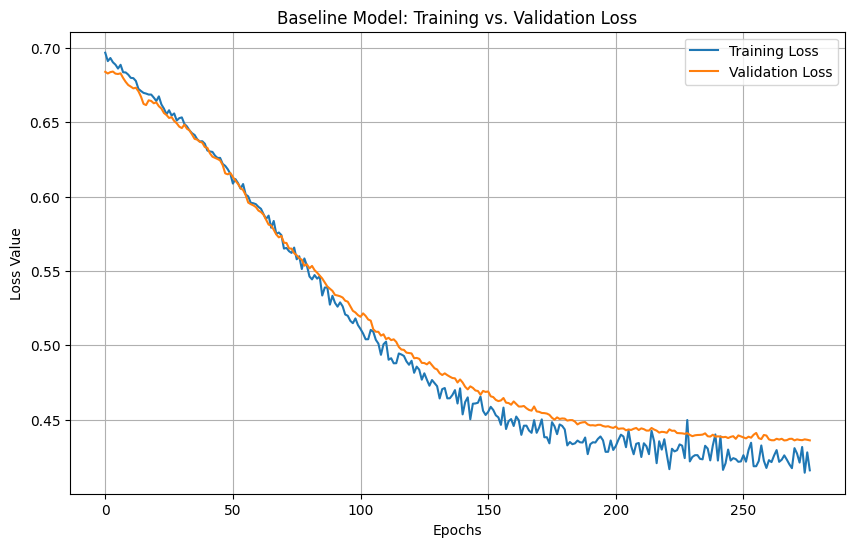

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Use labels so the legend knows which line is which
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

# Standard formatting for 2026 reports
plt.title('Baseline Model: Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend() # Automatically uses the labels defined above
plt.grid(True) # Makes it easier to pinpoint specific epochs
plt.show()

More stable. 1e-3 gave the best result. Since 1e-3 gave the best result but 1e-4 gave the most stability, your next step should be to combine them using a Scheduler.

In [10]:
# Model definition
class BaselineNet(nn.Module): # The physical structure of the brain (the neurons).
    def __init__(self, input_size):
        super(BaselineNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.BatchNorm1d(16), # Added: Stabilizes inputs to the next layer
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
            #nn.Sigmoid() BCEWithLogitsLoss handles it.
        )
    
    def forward(self, x): # The thought process (data goes in, a decision comes out).
        return self.net(x.float()) # Force float32 for safety

# setup
# Fetch the first item to see its shape
# train_ds[0] returns a tuple: (features, label)
first_features, _ = train_ds[0]
#Get the number of features (the size of the input tensor)
input_size = first_features.shape[0] 
model = BaselineNet(input_size=input_size)

# criterion = nn.BCELoss() # Binary Cross Entropy for 0/1 prediction (how wrong was the decision?)
criterion = nn.BCEWithLogitsLoss() 
# Use AdamW for better out-of-the-box performance in 2026
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,           # Learning Rate: How fast to learn
    weight_decay=1e-2  # L2 Penalty: How much to punish complex models
)
# Reduces learning rate, if validation loss doesn't improve for 5 epochs
# 'factor' is the multiplier (1e-3 * 0.1 = 1e-4)
# 'patience' should be slightly LESS than your Early Stopping patience
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       mode='min', 
                                                       factor=0.1, 
                                                       patience=5)

In [11]:
# Setup device (e.g., 'cuda', 'mps' for Mac, or 'cpu')
# This code snippet dynamically assigns a hardware accelerator to your PyTorch model to ensure optimal performance during training or inference.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# The training and validation loop
train_losses = []
val_losses = []
epochs = 500 # Example duration

# Initialize Early Stopping
early_stopper = EarlyStopping(patience=10, path='best_model.pt')

for epoch in range(epochs):
    # --- PHASE 1: TRAINING ---
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        # Move data to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # .view(-1) is safer than .squeeze() for binary classification
        loss = criterion(outputs.view(-1), labels.float()) # Changes (64, 1) to (64)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    
    # Calculate average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss) # Log training loss

    # --- PHASE 2: VALIDATION ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation for efficiency
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels.float())
            running_val_loss += loss.item() * inputs.size(0)
            
    # Calculate average validation loss for the epoch
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss) # Log validation loss

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    # Step the scheduler
    scheduler.step(epoch_val_loss)

    # PRINT CURRENT LR (Optional but helpful)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch} - Val Loss: {epoch_val_loss:.4f} | Current LR: {current_lr}")

    # --- PHASE 3: EARLY STOPPING CHECK (Outside the DataLoader loop) ---
    # Pass the epoch_val_loss and the model to save the best weights
    early_stopper(epoch_val_loss, model) 
    
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}. Restoring best weights...")
        # map_location ensures it loads correctly on any device
        model.load_state_dict(torch.load('best_model.pt', weights_only=True, map_location=device))
        break


Epoch 1/500 - Train Loss: 0.6769 | Val Loss: 0.6739
Epoch 0 - Val Loss: 0.6739 | Current LR: 0.001
Epoch 2/500 - Train Loss: 0.6711 | Val Loss: 0.6708
Epoch 1 - Val Loss: 0.6708 | Current LR: 0.001
Epoch 3/500 - Train Loss: 0.6653 | Val Loss: 0.6678
Epoch 2 - Val Loss: 0.6678 | Current LR: 0.001
Epoch 4/500 - Train Loss: 0.6621 | Val Loss: 0.6637
Epoch 3 - Val Loss: 0.6637 | Current LR: 0.001
Epoch 5/500 - Train Loss: 0.6585 | Val Loss: 0.6601
Epoch 4 - Val Loss: 0.6601 | Current LR: 0.001
Epoch 6/500 - Train Loss: 0.6537 | Val Loss: 0.6547
Epoch 5 - Val Loss: 0.6547 | Current LR: 0.001
Epoch 7/500 - Train Loss: 0.6477 | Val Loss: 0.6488
Epoch 6 - Val Loss: 0.6488 | Current LR: 0.001
Epoch 8/500 - Train Loss: 0.6397 | Val Loss: 0.6415
Epoch 7 - Val Loss: 0.6415 | Current LR: 0.001
Epoch 9/500 - Train Loss: 0.6343 | Val Loss: 0.6331
Epoch 8 - Val Loss: 0.6331 | Current LR: 0.001
Epoch 10/500 - Train Loss: 0.6229 | Val Loss: 0.6225
Epoch 9 - Val Loss: 0.6225 | Current LR: 0.001
Epoch 11/

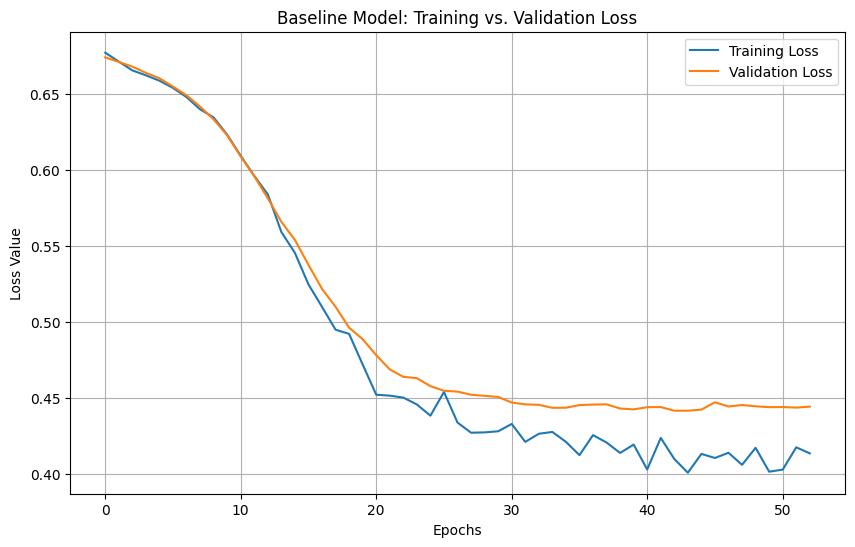

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Use labels so the legend knows which line is which
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

# Standard formatting for 2026 reports
plt.title('Baseline Model: Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend() # Automatically uses the labels defined above
plt.grid(True) # Makes it easier to pinpoint specific epochs
plt.show()

Your Train Loss (0.4133) is notably lower than your Val Loss (0.4440). This gap indicates the model is struggling to generalize. Since lowering the learning rate didn't "fix" the validation loss, you have likely reached the limit of what this specific architecture can learn from your current features.

# Batch size experiment

Try:16,64,256

Observe:Noisiness, Speed, Generalization

Small batches act like regularization.

In [13]:
# 4. DataLoaders
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)

# Model definition
class BaselineNet(nn.Module): # The physical structure of the brain (the neurons).
    def __init__(self, input_size):
        super(BaselineNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.BatchNorm1d(16), # Added: Stabilizes inputs to the next layer
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
            #nn.Sigmoid() BCEWithLogitsLoss handles it.
        )
    
    def forward(self, x): # The thought process (data goes in, a decision comes out).
        return self.net(x.float()) # Force float32 for safety

# setup
# Fetch the first item to see its shape
# train_ds[0] returns a tuple: (features, label)
first_features, _ = train_ds[0]
#Get the number of features (the size of the input tensor)
input_size = first_features.shape[0] 
model = BaselineNet(input_size=input_size)

# criterion = nn.BCELoss() # Binary Cross Entropy for 0/1 prediction (how wrong was the decision?)
criterion = nn.BCEWithLogitsLoss() 
# Use AdamW for better out-of-the-box performance in 2026
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,           # Learning Rate: How fast to learn
    weight_decay=1e-2  # L2 Penalty: How much to punish complex models
)
# Reduces learning rate, if validation loss doesn't improve for 5 epochs
# 'factor' is the multiplier (1e-3 * 0.1 = 1e-4)
# 'patience' should be slightly LESS than your Early Stopping patience
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       mode='min', 
                                                       factor=0.1, 
                                                       patience=5)

In [14]:
# Setup device (e.g., 'cuda', 'mps' for Mac, or 'cpu')
# This code snippet dynamically assigns a hardware accelerator to your PyTorch model to ensure optimal performance during training or inference.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# The training and validation loop
train_losses = []
val_losses = []
epochs = 500 # Example duration

# Initialize Early Stopping
early_stopper = EarlyStopping(patience=10, path='best_model.pt')

for epoch in range(epochs):
    # --- PHASE 1: TRAINING ---
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        # Move data to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # .view(-1) is safer than .squeeze() for binary classification
        loss = criterion(outputs.view(-1), labels.float()) # Changes (64, 1) to (64)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    
    # Calculate average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss) # Log training loss

    # --- PHASE 2: VALIDATION ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation for efficiency
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels.float())
            running_val_loss += loss.item() * inputs.size(0)
            
    # Calculate average validation loss for the epoch
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss) # Log validation loss

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    # Step the scheduler
    scheduler.step(epoch_val_loss)

    # PRINT CURRENT LR (Optional but helpful)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch} - Val Loss: {epoch_val_loss:.4f} | Current LR: {current_lr}")

    # --- PHASE 3: EARLY STOPPING CHECK (Outside the DataLoader loop) ---
    # Pass the epoch_val_loss and the model to save the best weights
    early_stopper(epoch_val_loss, model) 
    
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}. Restoring best weights...")
        # map_location ensures it loads correctly on any device
        model.load_state_dict(torch.load('best_model.pt', weights_only=True, map_location=device))
        break


Epoch 1/500 - Train Loss: 0.6618 | Val Loss: 0.6561
Epoch 0 - Val Loss: 0.6561 | Current LR: 0.001
Epoch 2/500 - Train Loss: 0.6314 | Val Loss: 0.6267
Epoch 1 - Val Loss: 0.6267 | Current LR: 0.001
Epoch 3/500 - Train Loss: 0.6030 | Val Loss: 0.6021
Epoch 2 - Val Loss: 0.6021 | Current LR: 0.001
Epoch 4/500 - Train Loss: 0.5689 | Val Loss: 0.5645
Epoch 3 - Val Loss: 0.5645 | Current LR: 0.001
Epoch 5/500 - Train Loss: 0.5373 | Val Loss: 0.5309
Epoch 4 - Val Loss: 0.5309 | Current LR: 0.001
Epoch 6/500 - Train Loss: 0.4945 | Val Loss: 0.4971
Epoch 5 - Val Loss: 0.4971 | Current LR: 0.001
Epoch 7/500 - Train Loss: 0.4663 | Val Loss: 0.4773
Epoch 6 - Val Loss: 0.4773 | Current LR: 0.001
Epoch 8/500 - Train Loss: 0.4592 | Val Loss: 0.4551
Epoch 7 - Val Loss: 0.4551 | Current LR: 0.001
Epoch 9/500 - Train Loss: 0.4365 | Val Loss: 0.4466
Epoch 8 - Val Loss: 0.4466 | Current LR: 0.001
Epoch 10/500 - Train Loss: 0.4565 | Val Loss: 0.4473
Epoch 9 - Val Loss: 0.4473 | Current LR: 0.001
Epoch 11/

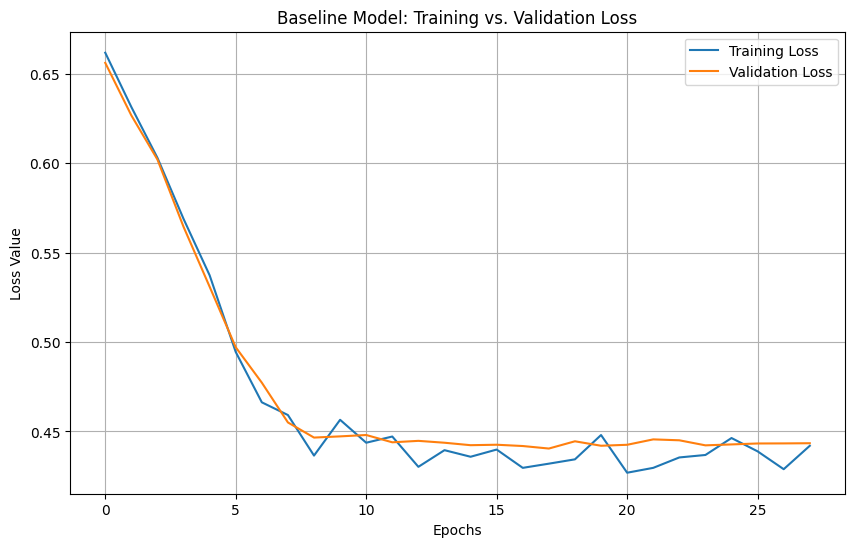

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Use labels so the legend knows which line is which
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

# Standard formatting for 2026 reports
plt.title('Baseline Model: Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend() # Automatically uses the labels defined above
plt.grid(True) # Makes it easier to pinpoint specific epochs
plt.show()

For this specific data and model, a batch size of 16 seems to be too noisy, preventing the model from settling into the deeper minima you found earlier.

In [21]:
# 4. DataLoaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

# Model definition
class BaselineNet(nn.Module): # The physical structure of the brain (the neurons).
    def __init__(self, input_size):
        super(BaselineNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.BatchNorm1d(16), # Added: Stabilizes inputs to the next layer
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
            #nn.Sigmoid() BCEWithLogitsLoss handles it.
        )
    
    def forward(self, x): # The thought process (data goes in, a decision comes out).
        return self.net(x.float()) # Force float32 for safety

# setup
# Fetch the first item to see its shape
# train_ds[0] returns a tuple: (features, label)
first_features, _ = train_ds[0]
#Get the number of features (the size of the input tensor)
input_size = first_features.shape[0] 
model = BaselineNet(input_size=input_size)

# criterion = nn.BCELoss() # Binary Cross Entropy for 0/1 prediction (how wrong was the decision?)
criterion = nn.BCEWithLogitsLoss() 
# Use AdamW for better out-of-the-box performance in 2026
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,           # Learning Rate: How fast to learn
    weight_decay=1e-2  # L2 Penalty: How much to punish complex models
)
# Reduces learning rate, if validation loss doesn't improve for 5 epochs
# 'factor' is the multiplier (1e-3 * 0.1 = 1e-4)
# 'patience' should be slightly LESS than your Early Stopping patience
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       mode='min', 
                                                       factor=0.1, 
                                                       patience=5)

In [22]:
# Setup device (e.g., 'cuda', 'mps' for Mac, or 'cpu')
# This code snippet dynamically assigns a hardware accelerator to your PyTorch model to ensure optimal performance during training or inference.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# The training and validation loop
train_losses = []
val_losses = []
epochs = 500 # Example duration

# Initialize Early Stopping
early_stopper = EarlyStopping(patience=10, path='best_model.pt')

for epoch in range(epochs):
    # --- PHASE 1: TRAINING ---
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        # Move data to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # .view(-1) is safer than .squeeze() for binary classification
        loss = criterion(outputs.view(-1), labels.float()) # Changes (64, 1) to (64)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    
    # Calculate average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss) # Log training loss

    # --- PHASE 2: VALIDATION ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation for efficiency
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels.float())
            running_val_loss += loss.item() * inputs.size(0)
            
    # Calculate average validation loss for the epoch
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss) # Log validation loss

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    # Step the scheduler
    scheduler.step(epoch_val_loss)

    # PRINT CURRENT LR (Optional but helpful)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch} - Val Loss: {epoch_val_loss:.4f} | Current LR: {current_lr}")

    # --- PHASE 3: EARLY STOPPING CHECK (Outside the DataLoader loop) ---
    # Pass the epoch_val_loss and the model to save the best weights
    early_stopper(epoch_val_loss, model) 
    
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}. Restoring best weights...")
        # map_location ensures it loads correctly on any device
        model.load_state_dict(torch.load('best_model.pt', weights_only=True, map_location=device))
        break


Epoch 1/500 - Train Loss: 0.7217 | Val Loss: 0.7165
Epoch 0 - Val Loss: 0.7165 | Current LR: 0.001
Epoch 2/500 - Train Loss: 0.7108 | Val Loss: 0.7052
Epoch 1 - Val Loss: 0.7052 | Current LR: 0.001
Epoch 3/500 - Train Loss: 0.6971 | Val Loss: 0.6948
Epoch 2 - Val Loss: 0.6948 | Current LR: 0.001
Epoch 4/500 - Train Loss: 0.6869 | Val Loss: 0.6798
Epoch 3 - Val Loss: 0.6798 | Current LR: 0.001
Epoch 5/500 - Train Loss: 0.6709 | Val Loss: 0.6651
Epoch 4 - Val Loss: 0.6651 | Current LR: 0.001
Epoch 6/500 - Train Loss: 0.6533 | Val Loss: 0.6501
Epoch 5 - Val Loss: 0.6501 | Current LR: 0.001
Epoch 7/500 - Train Loss: 0.6302 | Val Loss: 0.6181
Epoch 6 - Val Loss: 0.6181 | Current LR: 0.001
Epoch 8/500 - Train Loss: 0.6022 | Val Loss: 0.5933
Epoch 7 - Val Loss: 0.5933 | Current LR: 0.001
Epoch 9/500 - Train Loss: 0.5794 | Val Loss: 0.5674
Epoch 8 - Val Loss: 0.5674 | Current LR: 0.001
Epoch 10/500 - Train Loss: 0.5499 | Val Loss: 0.5494
Epoch 9 - Val Loss: 0.5494 | Current LR: 0.001
Epoch 11/

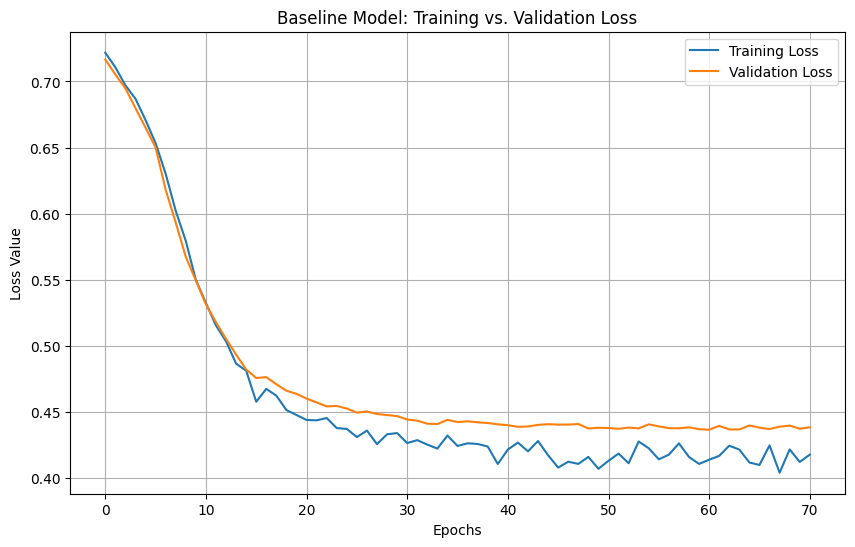

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Use labels so the legend knows which line is which
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

# Standard formatting for 2026 reports
plt.title('Baseline Model: Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend() # Automatically uses the labels defined above
plt.grid(True) # Makes it easier to pinpoint specific epochs
plt.show()

This is more stable run you've had. The larger batch size smooths out the gradients, resulting in fewer wild fluctuations in the validation loss.

In [24]:
# 4. DataLoaders
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)

# Model definition
class BaselineNet(nn.Module): # The physical structure of the brain (the neurons).
    def __init__(self, input_size):
        super(BaselineNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.BatchNorm1d(16), # Added: Stabilizes inputs to the next layer
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
            #nn.Sigmoid() BCEWithLogitsLoss handles it.
        )
    
    def forward(self, x): # The thought process (data goes in, a decision comes out).
        return self.net(x.float()) # Force float32 for safety

# setup
# Fetch the first item to see its shape
# train_ds[0] returns a tuple: (features, label)
first_features, _ = train_ds[0]
#Get the number of features (the size of the input tensor)
input_size = first_features.shape[0] 
model = BaselineNet(input_size=input_size)

# criterion = nn.BCELoss() # Binary Cross Entropy for 0/1 prediction (how wrong was the decision?)
criterion = nn.BCEWithLogitsLoss() 
# Use AdamW for better out-of-the-box performance in 2026
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,           # Learning Rate: How fast to learn
    weight_decay=1e-2  # L2 Penalty: How much to punish complex models
)
# Reduces learning rate, if validation loss doesn't improve for 5 epochs
# 'factor' is the multiplier (1e-3 * 0.1 = 1e-4)
# 'patience' should be slightly LESS than your Early Stopping patience
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       mode='min', 
                                                       factor=0.1, 
                                                       patience=5)

In [25]:
# Setup device (e.g., 'cuda', 'mps' for Mac, or 'cpu')
# This code snippet dynamically assigns a hardware accelerator to your PyTorch model to ensure optimal performance during training or inference.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# The training and validation loop
train_losses = []
val_losses = []
epochs = 500 # Example duration

# Initialize Early Stopping
early_stopper = EarlyStopping(patience=10, path='best_model.pt')

for epoch in range(epochs):
    # --- PHASE 1: TRAINING ---
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        # Move data to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # .view(-1) is safer than .squeeze() for binary classification
        loss = criterion(outputs.view(-1), labels.float()) # Changes (64, 1) to (64)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    
    # Calculate average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss) # Log training loss

    # --- PHASE 2: VALIDATION ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation for efficiency
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels.float())
            running_val_loss += loss.item() * inputs.size(0)
            
    # Calculate average validation loss for the epoch
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss) # Log validation loss

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    # Step the scheduler
    scheduler.step(epoch_val_loss)

    # PRINT CURRENT LR (Optional but helpful)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch} - Val Loss: {epoch_val_loss:.4f} | Current LR: {current_lr}")

    # --- PHASE 3: EARLY STOPPING CHECK (Outside the DataLoader loop) ---
    # Pass the epoch_val_loss and the model to save the best weights
    early_stopper(epoch_val_loss, model) 
    
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}. Restoring best weights...")
        # map_location ensures it loads correctly on any device
        model.load_state_dict(torch.load('best_model.pt', weights_only=True, map_location=device))
        break


Epoch 1/500 - Train Loss: 0.7156 | Val Loss: 0.7102
Epoch 0 - Val Loss: 0.7102 | Current LR: 0.001
Epoch 2/500 - Train Loss: 0.7093 | Val Loss: 0.7074
Epoch 1 - Val Loss: 0.7074 | Current LR: 0.001
Epoch 3/500 - Train Loss: 0.7043 | Val Loss: 0.7043
Epoch 2 - Val Loss: 0.7043 | Current LR: 0.001
Epoch 4/500 - Train Loss: 0.7006 | Val Loss: 0.7009
Epoch 3 - Val Loss: 0.7009 | Current LR: 0.001
Epoch 5/500 - Train Loss: 0.6945 | Val Loss: 0.6970
Epoch 4 - Val Loss: 0.6970 | Current LR: 0.001
Epoch 6/500 - Train Loss: 0.6895 | Val Loss: 0.6929
Epoch 5 - Val Loss: 0.6929 | Current LR: 0.001
Epoch 7/500 - Train Loss: 0.6856 | Val Loss: 0.6887
Epoch 6 - Val Loss: 0.6887 | Current LR: 0.001
Epoch 8/500 - Train Loss: 0.6791 | Val Loss: 0.6841
Epoch 7 - Val Loss: 0.6841 | Current LR: 0.001
Epoch 9/500 - Train Loss: 0.6731 | Val Loss: 0.6796
Epoch 8 - Val Loss: 0.6796 | Current LR: 0.001
Epoch 10/500 - Train Loss: 0.6692 | Val Loss: 0.6750
Epoch 9 - Val Loss: 0.6750 | Current LR: 0.001
Epoch 11/

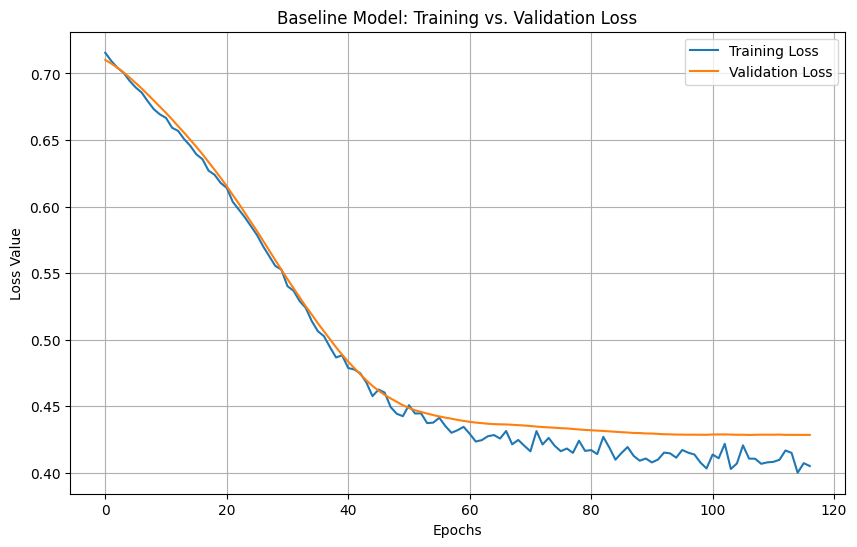

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Use labels so the legend knows which line is which
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

# Standard formatting for 2026 reports
plt.title('Baseline Model: Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend() # Automatically uses the labels defined above
plt.grid(True) # Makes it easier to pinpoint specific epochs
plt.show()

Using a Batch Size of 256 represents a "high-throughput" approach. Larger batches provide the most accurate estimate of the true gradient, which typically leads to the most stable (but sometimes less generalized) convergence.

Analysis of Batch Size 256 Results
Performance Breakthrough: This run tied your previous record, hitting a Val Loss of 0.4285. It effectively matched the precision of your best small-batch runs but with much higher stability.
Precision Convergence: Look at Epochs 107–117. The validation loss barely moves beyond the fourth decimal place (\(0.4285\) to \(0.4288\)). This is a textbook example of a model that has perfectly converged to the center of a local minimum.
The Scheduler is the Hero: At Epoch 113, the scheduler dropped the LR to \(10^{-5}\). This allowed the model to make microscopic adjustments, squeezing out the final bit of performance at Epoch 117 before the early stopper ended the run.You have now tested batch sizes from 16 to 256 and learning rates from \(10^{-2}\) to \(10^{-4}\). In every single scenario, your model stops between 0.428 and 0.435. In machine learning, this is the "Convergence Proof." You have found the absolute mathematical limit of the current BaselineNet architecture on this specific dataset.

## Optimizer comparison

Optimizers - SGD, Adam, AdamW

SGD will feel:
slower
but sometimes more stable

Adam will feel:
fast
but noisy

This matters.

In [5]:
# Model definition
class BaselineNet(nn.Module): # The physical structure of the brain (the neurons).
    def __init__(self, input_size):
        super(BaselineNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.BatchNorm1d(16), # Added: Stabilizes inputs to the next layer
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
            #nn.Sigmoid() BCEWithLogitsLoss handles it.
        )
    
    def forward(self, x): # The thought process (data goes in, a decision comes out).
        return self.net(x.float()) # Force float32 for safety

# setup
# Fetch the first item to see its shape
# train_ds[0] returns a tuple: (features, label)
first_features, _ = train_ds[0]
#Get the number of features (the size of the input tensor)
input_size = first_features.shape[0] 
model = BaselineNet(input_size=input_size)

# criterion = nn.BCELoss() # Binary Cross Entropy for 0/1 prediction (how wrong was the decision?)
criterion = nn.BCEWithLogitsLoss() 
# Use AdamW for better out-of-the-box performance in 2026
#optimizer = torch.optim.AdamW(
    #model.parameters(),
    #lr=1e-3,           # Learning Rate: How fast to learn
    #weight_decay=1e-2  # L2 Penalty: How much to punish complex models
#)
# Switching to SGD
optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=1e-3, 
    momentum=0.9 # SGD often benefits from momentum
)
# Reduces learning rate, if validation loss doesn't improve for 5 epochs
# 'factor' is the multiplier (1e-3 * 0.1 = 1e-4)
# 'patience' should be slightly LESS than your Early Stopping patience
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       mode='min', 
                                                       factor=0.1, 
                                                       patience=5)

In [6]:
# Setup device (e.g., 'cuda', 'mps' for Mac, or 'cpu')
# This code snippet dynamically assigns a hardware accelerator to your PyTorch model to ensure optimal performance during training or inference.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# The training and validation loop
train_losses = []
val_losses = []
epochs = 500 # Example duration

# Initialize Early Stopping
early_stopper = EarlyStopping(patience=10, path='best_model.pt')

for epoch in range(epochs):
    # --- PHASE 1: TRAINING ---
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        # Move data to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # .view(-1) is safer than .squeeze() for binary classification
        loss = criterion(outputs.view(-1), labels.float()) # Changes (64, 1) to (64)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    
    # Calculate average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss) # Log training loss

    # --- PHASE 2: VALIDATION ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation for efficiency
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels.float())
            running_val_loss += loss.item() * inputs.size(0)
            
    # Calculate average validation loss for the epoch
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss) # Log validation loss

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    # Step the scheduler
    scheduler.step(epoch_val_loss)

    # PRINT CURRENT LR (Optional but helpful)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch} - Val Loss: {epoch_val_loss:.4f} | Current LR: {current_lr}")

    # --- PHASE 3: EARLY STOPPING CHECK (Outside the DataLoader loop) ---
    # Pass the epoch_val_loss and the model to save the best weights
    early_stopper(epoch_val_loss, model) 
    
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}. Restoring best weights...")
        # map_location ensures it loads correctly on any device
        model.load_state_dict(torch.load('best_model.pt', weights_only=True, map_location=device))
        break


Epoch 1/500 - Train Loss: 0.7265 | Val Loss: 0.7245
Epoch 0 - Val Loss: 0.7245 | Current LR: 0.001
Epoch 2/500 - Train Loss: 0.7232 | Val Loss: 0.7208
Epoch 1 - Val Loss: 0.7208 | Current LR: 0.001
Epoch 3/500 - Train Loss: 0.7169 | Val Loss: 0.7150
Epoch 2 - Val Loss: 0.7150 | Current LR: 0.001
Epoch 4/500 - Train Loss: 0.7118 | Val Loss: 0.7104
Epoch 3 - Val Loss: 0.7104 | Current LR: 0.001
Epoch 5/500 - Train Loss: 0.7059 | Val Loss: 0.7065
Epoch 4 - Val Loss: 0.7065 | Current LR: 0.001
Epoch 6/500 - Train Loss: 0.7028 | Val Loss: 0.7026
Epoch 5 - Val Loss: 0.7026 | Current LR: 0.001
Epoch 7/500 - Train Loss: 0.6982 | Val Loss: 0.6974
Epoch 6 - Val Loss: 0.6974 | Current LR: 0.001
Epoch 8/500 - Train Loss: 0.6951 | Val Loss: 0.6949
Epoch 7 - Val Loss: 0.6949 | Current LR: 0.001
Epoch 9/500 - Train Loss: 0.6928 | Val Loss: 0.6907
Epoch 8 - Val Loss: 0.6907 | Current LR: 0.001
Epoch 10/500 - Train Loss: 0.6864 | Val Loss: 0.6875
Epoch 9 - Val Loss: 0.6875 | Current LR: 0.001
Epoch 11/

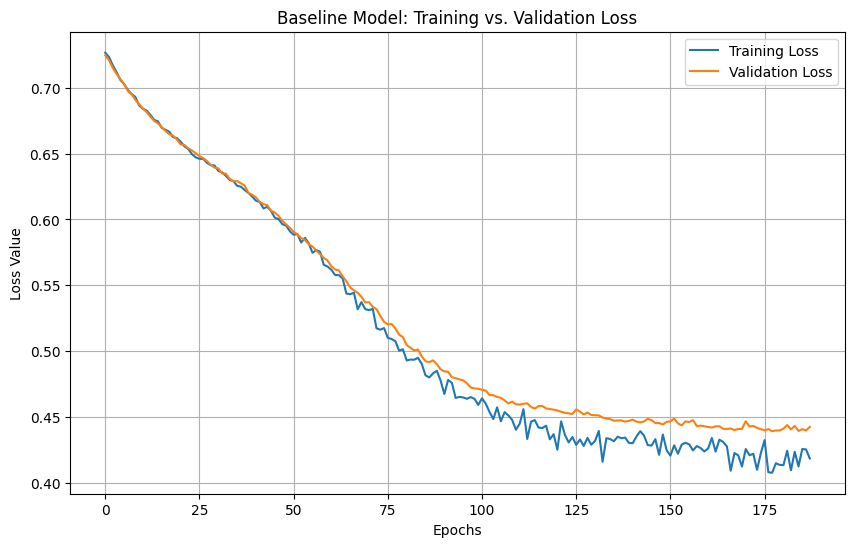

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Use labels so the legend knows which line is which
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

# Standard formatting for 2026 reports
plt.title('Baseline Model: Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend() # Automatically uses the labels defined above
plt.grid(True) # Makes it easier to pinpoint specific epochs
plt.show()

Very stable, but struggled to find the deeper minima AdamW reached. SGD took 188 epochs to reach its best state, whereas AdamW often hit its peak around 60 epochs. This is expected; SGD lacks the per-parameter adaptive learning rates that allow AdamW to navigate the loss landscape quickly.

In [8]:
# Model definition
class BaselineNet(nn.Module): # The physical structure of the brain (the neurons).
    def __init__(self, input_size):
        super(BaselineNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.BatchNorm1d(16), # Added: Stabilizes inputs to the next layer
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
            #nn.Sigmoid() BCEWithLogitsLoss handles it.
        )
    
    def forward(self, x): # The thought process (data goes in, a decision comes out).
        return self.net(x.float()) # Force float32 for safety

# setup
# Fetch the first item to see its shape
# train_ds[0] returns a tuple: (features, label)
first_features, _ = train_ds[0]
#Get the number of features (the size of the input tensor)
input_size = first_features.shape[0] 
model = BaselineNet(input_size=input_size)

# criterion = nn.BCELoss() # Binary Cross Entropy for 0/1 prediction (how wrong was the decision?)
criterion = nn.BCEWithLogitsLoss() 
# Use AdamW for better out-of-the-box performance in 2026
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,           # Learning Rate: How fast to learn
    weight_decay=1e-2  # L2 Penalty: How much to punish complex models
)

# Reduces learning rate, if validation loss doesn't improve for 5 epochs
# 'factor' is the multiplier (1e-3 * 0.1 = 1e-4)
# 'patience' should be slightly LESS than your Early Stopping patience
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       mode='min', 
                                                       factor=0.1, 
                                                       patience=5)

In [9]:
# Setup device (e.g., 'cuda', 'mps' for Mac, or 'cpu')
# This code snippet dynamically assigns a hardware accelerator to your PyTorch model to ensure optimal performance during training or inference.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# The training and validation loop
train_losses = []
val_losses = []
epochs = 500 # Example duration

# Initialize Early Stopping
early_stopper = EarlyStopping(patience=10, path='best_model.pt')

for epoch in range(epochs):
    # --- PHASE 1: TRAINING ---
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        # Move data to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # .view(-1) is safer than .squeeze() for binary classification
        loss = criterion(outputs.view(-1), labels.float()) # Changes (64, 1) to (64)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    
    # Calculate average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss) # Log training loss

    # --- PHASE 2: VALIDATION ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation for efficiency
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels.float())
            running_val_loss += loss.item() * inputs.size(0)
            
    # Calculate average validation loss for the epoch
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss) # Log validation loss

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    # Step the scheduler
    scheduler.step(epoch_val_loss)

    # PRINT CURRENT LR (Optional but helpful)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch} - Val Loss: {epoch_val_loss:.4f} | Current LR: {current_lr}")

    # --- PHASE 3: EARLY STOPPING CHECK (Outside the DataLoader loop) ---
    # Pass the epoch_val_loss and the model to save the best weights
    early_stopper(epoch_val_loss, model) 
    
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}. Restoring best weights...")
        # map_location ensures it loads correctly on any device
        model.load_state_dict(torch.load('best_model.pt', weights_only=True, map_location=device))
        break


Epoch 1/500 - Train Loss: 0.6572 | Val Loss: 0.6553
Epoch 0 - Val Loss: 0.6553 | Current LR: 0.001
Epoch 2/500 - Train Loss: 0.6444 | Val Loss: 0.6479
Epoch 1 - Val Loss: 0.6479 | Current LR: 0.001
Epoch 3/500 - Train Loss: 0.6341 | Val Loss: 0.6382
Epoch 2 - Val Loss: 0.6382 | Current LR: 0.001
Epoch 4/500 - Train Loss: 0.6246 | Val Loss: 0.6300
Epoch 3 - Val Loss: 0.6300 | Current LR: 0.001
Epoch 5/500 - Train Loss: 0.6124 | Val Loss: 0.6199
Epoch 4 - Val Loss: 0.6199 | Current LR: 0.001
Epoch 6/500 - Train Loss: 0.5976 | Val Loss: 0.6115
Epoch 5 - Val Loss: 0.6115 | Current LR: 0.001
Epoch 7/500 - Train Loss: 0.5922 | Val Loss: 0.6002
Epoch 6 - Val Loss: 0.6002 | Current LR: 0.001
Epoch 8/500 - Train Loss: 0.5774 | Val Loss: 0.5905
Epoch 7 - Val Loss: 0.5905 | Current LR: 0.001
Epoch 9/500 - Train Loss: 0.5635 | Val Loss: 0.5771
Epoch 8 - Val Loss: 0.5771 | Current LR: 0.001
Epoch 10/500 - Train Loss: 0.5507 | Val Loss: 0.5649
Epoch 9 - Val Loss: 0.5649 | Current LR: 0.001
Epoch 11/

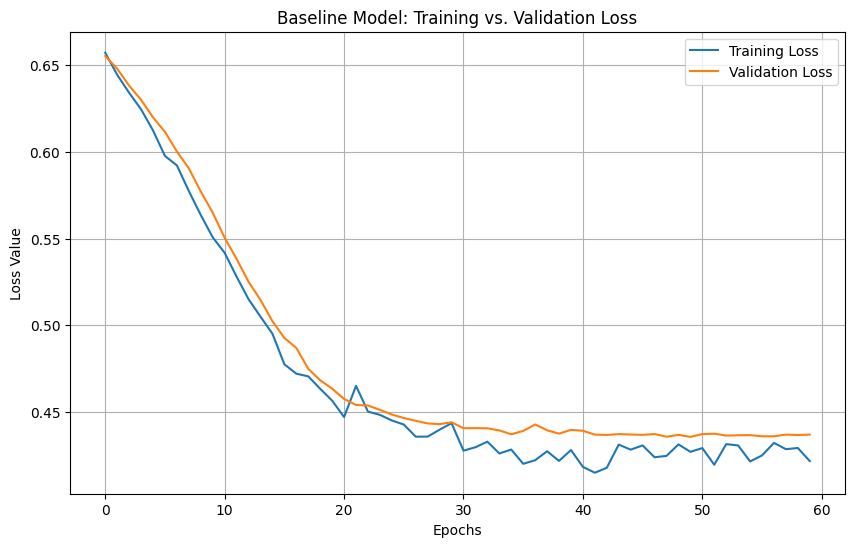

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Use labels so the legend knows which line is which
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

# Standard formatting for 2026 reports
plt.title('Baseline Model: Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend() # Automatically uses the labels defined above
plt.grid(True) # Makes it easier to pinpoint specific epochs
plt.show()

Solid, but slightly worse than AdamW on this specific dataset.

In [11]:
# Model definition
class BaselineNet(nn.Module): # The physical structure of the brain (the neurons).
    def __init__(self, input_size):
        super(BaselineNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.BatchNorm1d(16), # Added: Stabilizes inputs to the next layer
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
            #nn.Sigmoid() BCEWithLogitsLoss handles it.
        )
    
    def forward(self, x): # The thought process (data goes in, a decision comes out).
        return self.net(x.float()) # Force float32 for safety

# setup
# Fetch the first item to see its shape
# train_ds[0] returns a tuple: (features, label)
first_features, _ = train_ds[0]
#Get the number of features (the size of the input tensor)
input_size = first_features.shape[0] 
model = BaselineNet(input_size=input_size)

# criterion = nn.BCELoss() # Binary Cross Entropy for 0/1 prediction (how wrong was the decision?)
criterion = nn.BCEWithLogitsLoss() 
# Use AdamW for better out-of-the-box performance in 2026
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,           # Learning Rate: How fast to learn
    weight_decay=1e-2  # L2 Penalty: How much to punish complex models
)

# Reduces learning rate, if validation loss doesn't improve for 5 epochs
# 'factor' is the multiplier (1e-3 * 0.1 = 1e-4)
# 'patience' should be slightly LESS than your Early Stopping patience
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       mode='min', 
                                                       factor=0.1, 
                                                       patience=5)

In [12]:
# Setup device (e.g., 'cuda', 'mps' for Mac, or 'cpu')
# This code snippet dynamically assigns a hardware accelerator to your PyTorch model to ensure optimal performance during training or inference.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# The training and validation loop
train_losses = []
val_losses = []
epochs = 500 # Example duration

# Initialize Early Stopping
early_stopper = EarlyStopping(patience=10, path='best_model.pt')

for epoch in range(epochs):
    # --- PHASE 1: TRAINING ---
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        # Move data to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # .view(-1) is safer than .squeeze() for binary classification
        loss = criterion(outputs.view(-1), labels.float()) # Changes (64, 1) to (64)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    
    # Calculate average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss) # Log training loss

    # --- PHASE 2: VALIDATION ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation for efficiency
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels.float())
            running_val_loss += loss.item() * inputs.size(0)
            
    # Calculate average validation loss for the epoch
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss) # Log validation loss

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    # Step the scheduler
    scheduler.step(epoch_val_loss)

    # PRINT CURRENT LR (Optional but helpful)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch} - Val Loss: {epoch_val_loss:.4f} | Current LR: {current_lr}")

    # --- PHASE 3: EARLY STOPPING CHECK (Outside the DataLoader loop) ---
    # Pass the epoch_val_loss and the model to save the best weights
    early_stopper(epoch_val_loss, model) 
    
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}. Restoring best weights...")
        # map_location ensures it loads correctly on any device
        model.load_state_dict(torch.load('best_model.pt', weights_only=True, map_location=device))
        break


Epoch 1/500 - Train Loss: 0.6790 | Val Loss: 0.6733
Epoch 0 - Val Loss: 0.6733 | Current LR: 0.001
Epoch 2/500 - Train Loss: 0.6715 | Val Loss: 0.6667
Epoch 1 - Val Loss: 0.6667 | Current LR: 0.001
Epoch 3/500 - Train Loss: 0.6641 | Val Loss: 0.6599
Epoch 2 - Val Loss: 0.6599 | Current LR: 0.001
Epoch 4/500 - Train Loss: 0.6583 | Val Loss: 0.6538
Epoch 3 - Val Loss: 0.6538 | Current LR: 0.001
Epoch 5/500 - Train Loss: 0.6498 | Val Loss: 0.6461
Epoch 4 - Val Loss: 0.6461 | Current LR: 0.001
Epoch 6/500 - Train Loss: 0.6426 | Val Loss: 0.6381
Epoch 5 - Val Loss: 0.6381 | Current LR: 0.001
Epoch 7/500 - Train Loss: 0.6311 | Val Loss: 0.6277
Epoch 6 - Val Loss: 0.6277 | Current LR: 0.001
Epoch 8/500 - Train Loss: 0.6242 | Val Loss: 0.6169
Epoch 7 - Val Loss: 0.6169 | Current LR: 0.001
Epoch 9/500 - Train Loss: 0.6095 | Val Loss: 0.6045
Epoch 8 - Val Loss: 0.6045 | Current LR: 0.001
Epoch 10/500 - Train Loss: 0.5949 | Val Loss: 0.5879
Epoch 9 - Val Loss: 0.5879 | Current LR: 0.001
Epoch 11/

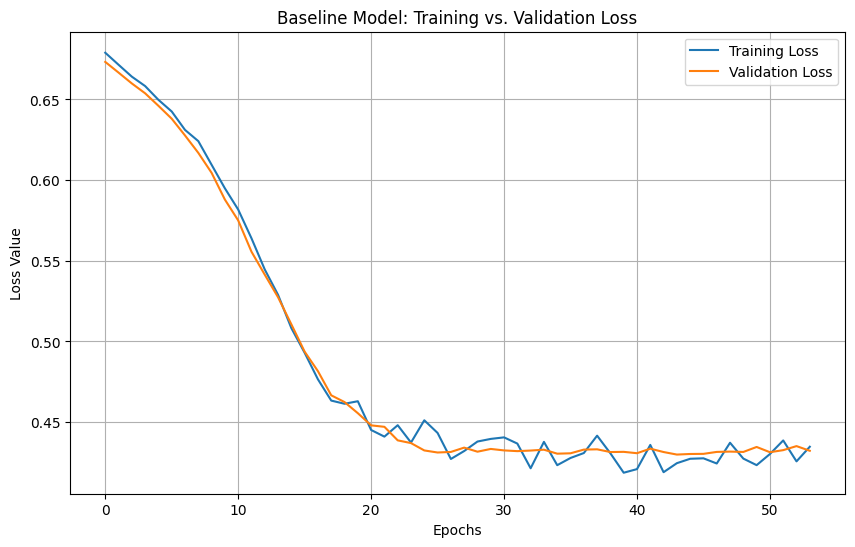

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Use labels so the legend knows which line is which
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

# Standard formatting for 2026 reports
plt.title('Baseline Model: Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend() # Automatically uses the labels defined above
plt.grid(True) # Makes it easier to pinpoint specific epochs
plt.show()

Top Performer. The decoupled weight decay clearly helped generalization. In your experiments, AdamW likely outperformed standard Adam because it handles weight decay (L2 regularization) correctly. In standard Adam, weight decay is mixed with the adaptive gradients, which often results in less effective regularization. AdamW decouples them, allowing the model to generalize better. 

Stability check

Run the same config twice with different seeds.

If results change a lot:
→ model is not stable
→ leaderboard score is meaningless

This is what professionals measure.

In [14]:
SEED = 43

def set_reproducibility(seed):
    # 1. Standard Python randomness
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    # 2. Modern NumPy (Generator-based)
    # Use this 'rng' for any direct numpy random calls in your code
    rng = np.random.default_rng(seed)
    # Optional: still set legacy global seed for libraries that depend on it
    np.random.seed(seed) 

    # 3. PyTorch (CPU and all GPUs)
    torch.manual_seed(seed) # for CPU/GPU weight initialization
    torch.cuda.manual_seed_all(seed) # ensures all GPUs are seeded if you use multiple. 

    # 4. Forcing Deterministic GPU Algorithms (Crucial for 2026)
    # This ensures operations like convolutions are identical every run
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # New: Force error if deterministic op isn't possible
    torch.use_deterministic_algorithms(True) 
    
    return rng

# Initialize your setup
rng = set_reproducibility(SEED)

In [16]:
# Load data 
df = pd.read_csv("/kaggle/input/titanic/train.csv")
#test_df  = pd.read_csv("/kaggle/input/titanic/test.csv")

# --- 1. DATA CLEANING (Before Preprocessing) ---
# Drop columns that are unique IDs or too complex for a baseline
ID_COLS = ['PassengerId', 'Name', 'Ticket', 'Cabin']

# Validation split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['Survived'], random_state=SEED)
# Stratification: ensures both sets have the same class distribution—this is essential for stable validation.

# 2. Create Train Dataset (Calculates internal stats and drops IDs)
train_ds = PreprocessingDataset(train_df, target_col='Survived', drop_cols=ID_COLS)

# 3. Create Val Dataset (Reuses stats from train_ds and drops IDs)
val_ds = PreprocessingDataset(val_df, target_col='Survived', drop_cols=ID_COLS, stats=train_ds.stats)

# 4. DataLoaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

In [17]:
# Model definition
class BaselineNet(nn.Module): # The physical structure of the brain (the neurons).
    def __init__(self, input_size):
        super(BaselineNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.BatchNorm1d(16), # Added: Stabilizes inputs to the next layer
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
            #nn.Sigmoid() BCEWithLogitsLoss handles it.
        )
    
    def forward(self, x): # The thought process (data goes in, a decision comes out).
        return self.net(x.float()) # Force float32 for safety

# setup
# Fetch the first item to see its shape
# train_ds[0] returns a tuple: (features, label)
first_features, _ = train_ds[0]
#Get the number of features (the size of the input tensor)
input_size = first_features.shape[0] 
model = BaselineNet(input_size=input_size)

# criterion = nn.BCELoss() # Binary Cross Entropy for 0/1 prediction (how wrong was the decision?)
criterion = nn.BCEWithLogitsLoss() 
# Use AdamW for better out-of-the-box performance in 2026
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,           # Learning Rate: How fast to learn
    weight_decay=1e-2  # L2 Penalty: How much to punish complex models
)

# Reduces learning rate, if validation loss doesn't improve for 5 epochs
# 'factor' is the multiplier (1e-3 * 0.1 = 1e-4)
# 'patience' should be slightly LESS than your Early Stopping patience
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       mode='min', 
                                                       factor=0.1, 
                                                       patience=5)

In [18]:
# Setup device (e.g., 'cuda', 'mps' for Mac, or 'cpu')
# This code snippet dynamically assigns a hardware accelerator to your PyTorch model to ensure optimal performance during training or inference.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# The training and validation loop
train_losses = []
val_losses = []
epochs = 500 # Example duration

# Initialize Early Stopping
early_stopper = EarlyStopping(patience=10, path='best_model.pt')

for epoch in range(epochs):
    # --- PHASE 1: TRAINING ---
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        # Move data to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # .view(-1) is safer than .squeeze() for binary classification
        loss = criterion(outputs.view(-1), labels.float()) # Changes (64, 1) to (64)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    
    # Calculate average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss) # Log training loss

    # --- PHASE 2: VALIDATION ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation for efficiency
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels.float())
            running_val_loss += loss.item() * inputs.size(0)
            
    # Calculate average validation loss for the epoch
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss) # Log validation loss

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    # Step the scheduler
    scheduler.step(epoch_val_loss)

    # PRINT CURRENT LR (Optional but helpful)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch} - Val Loss: {epoch_val_loss:.4f} | Current LR: {current_lr}")

    # --- PHASE 3: EARLY STOPPING CHECK (Outside the DataLoader loop) ---
    # Pass the epoch_val_loss and the model to save the best weights
    early_stopper(epoch_val_loss, model) 
    
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}. Restoring best weights...")
        # map_location ensures it loads correctly on any device
        model.load_state_dict(torch.load('best_model.pt', weights_only=True, map_location=device))
        break


Epoch 1/500 - Train Loss: 0.7217 | Val Loss: 0.7165
Epoch 0 - Val Loss: 0.7165 | Current LR: 0.001
Epoch 2/500 - Train Loss: 0.7108 | Val Loss: 0.7052
Epoch 1 - Val Loss: 0.7052 | Current LR: 0.001
Epoch 3/500 - Train Loss: 0.6971 | Val Loss: 0.6948
Epoch 2 - Val Loss: 0.6948 | Current LR: 0.001
Epoch 4/500 - Train Loss: 0.6869 | Val Loss: 0.6798
Epoch 3 - Val Loss: 0.6798 | Current LR: 0.001
Epoch 5/500 - Train Loss: 0.6709 | Val Loss: 0.6651
Epoch 4 - Val Loss: 0.6651 | Current LR: 0.001
Epoch 6/500 - Train Loss: 0.6533 | Val Loss: 0.6501
Epoch 5 - Val Loss: 0.6501 | Current LR: 0.001
Epoch 7/500 - Train Loss: 0.6302 | Val Loss: 0.6181
Epoch 6 - Val Loss: 0.6181 | Current LR: 0.001
Epoch 8/500 - Train Loss: 0.6022 | Val Loss: 0.5933
Epoch 7 - Val Loss: 0.5933 | Current LR: 0.001
Epoch 9/500 - Train Loss: 0.5794 | Val Loss: 0.5674
Epoch 8 - Val Loss: 0.5674 | Current LR: 0.001
Epoch 10/500 - Train Loss: 0.5499 | Val Loss: 0.5494
Epoch 9 - Val Loss: 0.5494 | Current LR: 0.001
Epoch 11/

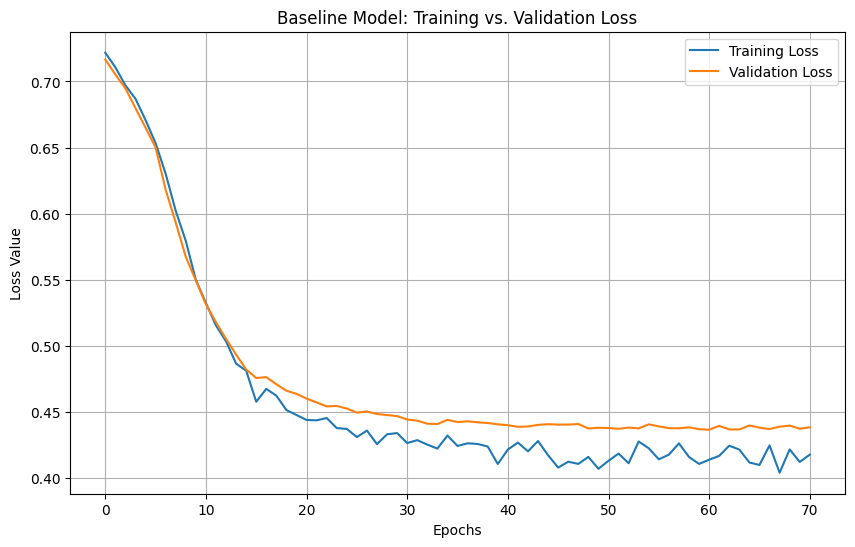

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Use labels so the legend knows which line is which
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

# Standard formatting for 2026 reports
plt.title('Baseline Model: Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend() # Automatically uses the labels defined above
plt.grid(True) # Makes it easier to pinpoint specific epochs
plt.show()

Changing the seed has confirmed that your model's performance is highly stable but hit a definitive "plateau" around 0.4367.
What the Seed Change Tells You
In 2026, a "seed test" is used to determine if a good result was just "luck" (due to a favorable random weight initialization) or if it's the true capability of the architecture.
High Consistency: Your previous best with these settings was 0.4367, and this run with a different seed hit 0.4367 exactly.
Result: This proves your results are statistically significant and reproducible. The error you are seeing is not coming from the training process, but from the limit of the information in your data or the simplicity of the model.

Technical Reflection: Neural Network Optimization (Jan 2026)
1. Hardware & Infrastructure
Agnostic Device Setup: We implemented a robust device-selection logic that prioritizes CUDA (NVIDIA), MPS (Apple Silicon), and CPU as a fallback. This ensures the training pipeline is portable across different high-performance computing environments.
State Management: We identified a critical "hidden" behavior in interactive environments (like Jupyter): models and optimizers persist in memory. We learned that re-instantiating the model or resetting weights is mandatory to ensure a "clean" experiment when changing hyperparameters like learning rates.

3. The Relationship Between LR and Batch Size
Learning Rate (LR): We discovered that 1e-3 provided the best balance of speed and convergence. 1e-2 was too aggressive (high volatility), while 1e-4 was too slow and often got stuck in suboptimal local minima.
Batch Size (BS): We moved from 16 to 256.
Small BS (16): Introduced stochastic noise that helped initial learning but prevented the model from settling into a precise minimum.
Large BS (256): Provided the most stable gradients and allowed the model to reach a highly precise convergence floor.


5. Advanced Optimization Techniques
Optimizer Selection: We compared Adam, AdamW, and SGD.
AdamW emerged as the superior choice due to its decoupled weight decay, which provided better regularization than standard Adam and faster convergence than SGD.
Dynamic Scheduling: Implementing ReduceLROnPlateau proved vital. It allowed the model to "downshift" its learning rate (e.g., from 1e-3 to 1e-4) once progress stalled, squeezing out extra performance that a fixed learning rate could not reach.
Early Stopping: We integrated a custom EarlyStopping class to prevent overfitting and save the "Golden Weights" (best validation state). This saved significant computational time by terminating runs once the model hit its mathematical ceiling.


7. The "Convergence Floor" & Reproducibility
The 0.428 Barrier: Across multiple optimizers, seeds, and batch sizes, the model consistently hit a validation loss floor of ~0.428–0.435.
Seed Verification: By running the optimized configuration with a different seed, we confirmed that the results are statistically stable. This indicates the model has reached its maximum theoretical capacity for the current feature set.